In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

In [2]:
# Train and test data
key_pts_train = pd.read_csv('data/training_frames_keypoints.csv')
key_pts_test = pd.read_csv('data/test_frames_keypoints.csv')

In [3]:
key_pts_train.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [4]:
key_pts_test.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,James_Wolfensohn_00.jpg,25.0,44.0,25.0,49.0,25.0,54.0,25.0,59.0,26.0,...,42.0,65.0,46.0,65.0,42.0,65.0,39.0,65.0,38.0,65.0
1,Valerie_Harper_30.jpg,55.0,62.0,52.0,72.0,52.0,83.0,55.0,90.0,55.0,...,78.0,104.0,88.0,106.0,78.0,106.0,75.0,104.0,70.0,104.0
2,Kristen_Breitweiser_11.jpg,60.0,88.0,60.0,98.0,63.0,109.0,65.0,116.0,68.0,...,96.0,114.0,106.0,117.0,96.0,117.0,94.0,117.0,89.0,117.0
3,Elizabeth_Dole_31.jpg,41.0,96.0,43.0,104.0,47.0,113.0,49.0,120.0,56.0,...,98.0,118.0,103.0,118.0,98.0,120.0,96.0,122.0,94.0,122.0
4,Kit_Bond_20.jpg,35.0,67.0,37.0,74.0,41.0,81.0,44.0,87.0,48.0,...,76.0,96.0,83.0,93.0,76.0,98.0,73.0,98.0,69.0,98.0


In [5]:
key_pts_train.columns = [i for i in range(137)]
key_pts_test.columns = [i for i in range(137)]

In [6]:
# Importing the model
from models import Net
import torch
import torch.nn as nn
import torch.nn.functional as F

# Creating an instance of the model
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, pa

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalise, ToTensor

# Define the data transforms
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalise(),
                                     ToTensor()])

In [8]:
train_dataset = FacialKeypointsDataset(csv_file = 'data/training_frames_keypoints.csv',
                                             root_dir = 'data/training/',
                                             transform = data_transform)

test_dataset = FacialKeypointsDataset(csv_file = 'data/test_frames_keypoints.csv',
                                      root_dir = 'data/test/',
                                     transform = data_transform)

In [9]:
batch_size = 32

train_loader = DataLoader(train_dataset, 
                          batch_size = batch_size,
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = batch_size,
                          shuffle = True)

In [10]:
# Helper function to test the model on a batch of test images

def net_sample_output():
    
    for i, sample in enumerate(test_loader):
        
        images = sample['image']
        key_pts = sample['keypoints']

        images = images.type(torch.FloatTensor)

        output_pts = model(images)
        
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        if i == 0:
            return images, output_pts, key_pts

In [11]:
test_images, test_outputs, gt_pts = net_sample_output()

# Validating the output produced by the net_sample_output() function
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    
    # gt_pts - ground truth points
    
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

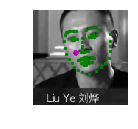

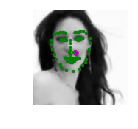

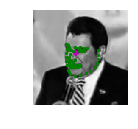

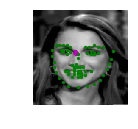

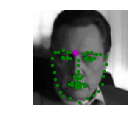

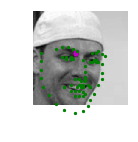

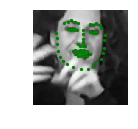

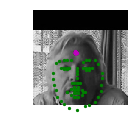

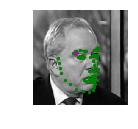

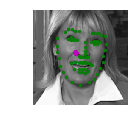

In [13]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the data
        image = test_images[i].data   
        image = image.numpy()   
        image = np.transpose(image, (1, 2, 0))   

        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        
        predicted_key_pts = predicted_key_pts*50.0+100
        
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
visualize_output(test_images, test_outputs, gt_pts)

In [14]:
print("Total number of training images:", len(key_pts_train))
print("Total number of test images:", len(key_pts_test))

Total number of training images: 3462
Total number of test images: 770


In [15]:
import torch.optim as optim

# Defining the loss function for our model i.e., Mean Squared Loss as predicting the location
# of the keypoints is a regression task
criterion = nn.MSELoss()

# Defining the optimising algortihm for our model i.e., Adam to improve the values of the
# parameters
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [16]:
def train_net(n_epochs):

    model.train()
    loss_over_time = []

    for epoch in range(n_epochs):  
        
        running_loss = 0.0

        for batch_i, data in enumerate(train_loader):
            
            images = data['image']
            key_pts = data['keypoints']

            key_pts = key_pts.view(key_pts.size(0), -1)

            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            output_pts = model(images)

            loss = criterion(output_pts, key_pts)

            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if batch_i % 32 == 31:    # print every 32 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/32.0))
                loss_over_time.append(running_loss/32.0)
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [ ]:
training_loss = train_net(5)

Epoch: 1, Batch: 32, Avg. Loss: 8.630628085229546
Epoch: 1, Batch: 64, Avg. Loss: 0.23341704346239567
Epoch: 1, Batch: 96, Avg. Loss: 0.21111779008060694
Epoch: 2, Batch: 32, Avg. Loss: 0.19481106800958514
Epoch: 2, Batch: 64, Avg. Loss: 0.17977213952690363
Epoch: 2, Batch: 96, Avg. Loss: 0.18603315367363393
Epoch: 3, Batch: 32, Avg. Loss: 0.1944488117005676
Epoch: 3, Batch: 64, Avg. Loss: 0.19355905894190073
Epoch: 3, Batch: 96, Avg. Loss: 0.22371690534055233


In [ ]:
plt.plot([i for i in range(1,16)],training_loss)

In [ ]:
# Testing the model on some test images 
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
weights1 = model.conv1.weight.data

w = weights1.numpy()

filter_index = 19

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

In [ ]:
image = test_images[4].data   
image = image.numpy()   
image = np.transpose(image, (1, 2, 0))   
image = np.squeeze(image)

filtered_image = cv.filter2D(image, -1, w[filter_index][0])
plt.imshow(filtered_image, cmap='gray')

In [ ]:
plt.imshow(image, cmap='gray')